In [7]:
from preprocessing import *
import pandas as pd
import os
from fst4conll import *
from conll import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [8]:
%%bash
dpath='NL2SparQL4NLU/dataset/NL2SparQL4NLU'
spath='dataset'
mkdir -p 'dataset'

cp $dpath.train.utterances.txt $spath/trn.txt
cp $dpath.test.utterances.txt $spath/tst.txt

cp $dpath.train.conll.txt $spath/trn.conll
cp $dpath.test.conll.txt $spath/tst.conll

## Baseline MLE

In [9]:
#generate files
if not os.path.exists('baseline'):
    os.makedirs('baseline')
tf_min=1
#INPUT
trn_data = read_corpus('dataset/trn.txt')
trn_lex, out = cutoff(trn_data, tf_min)

with open('baseline/isyms.trn.txt', 'w') as f:
    f.write("\n".join(trn_lex) + "\n")

#OUTPUT / LM
trn = read_corpus_conll('dataset/trn.conll')
tags = get_column(trn, column=-1)

with open('baseline/trn.t.txt', 'w') as f:
    for s in tags:
        f.write(" ".join(s) + "\n")
        
tlex, out_t = cutoff(tags, tf_min)

with open('baseline/osyms.t.lst.txt', 'w') as f:
    f.write("\n".join(tlex) + "\n")

In [10]:
%%bash
#make input/output lexicons
bpath='baseline'
ngramsymbols $bpath/isyms.trn.txt   $bpath/isyms.txt
ngramsymbols $bpath/osyms.t.lst.txt $bpath/osyms.t.txt

rm $bpath/isyms.trn.txt
rm $bpath/osyms.t.lst.txt

## Create Lexicon

In [11]:
%%bash 
#use lexicons with both cutoff
bpath='baseline'
cat $bpath/isyms.txt $bpath/osyms.t.txt | cut -f 1 | sort | uniq > $bpath/lex.lst.txt
ngramsymbols $bpath/lex.lst.txt $bpath/lex.txt

## Extract test sentences

In [11]:
%%bash
farcompilestrings \
    --symbols=baseline/lex.txt \
    --keep_symbols \
    --unknown_symbol='<unk>' \
    dataset/tst.txt tst.far
wdir='baseline/wdir'
mkdir -p 'baseline/wdir'
farextract --filename_prefix="$wdir/" tst.far

## Create MLE transducer w2t_mle

In [12]:
from collections import defaultdict
import math

# ---------------- if no cutoff ---------------------
if tf_min < 2:
    training_data = []
    with open('dataset/trn.conll') as f:
        content = f.read().strip('\n').split('\n\n')
        
    for sentence in content:
        list_wt = [(x.split('\t')[0], x.split('\t')[1]) for x in sentence.split('\n')]
        training_data += list_wt
     
    with open('baseline/w2t_mle.txt', 'w') as f:
        t_count = defaultdict(int)
        wt_count = defaultdict(int)
        p_wt = defaultdict(float)
        # count c(w,t) and c(t)
        for t in training_data:
            t_count[t[1]] += 1
            wt = "{} {}".format(t[0], t[1])
            wt_count[wt] += 1
               
        # compute prob p(w|t) with add-alpha smoothing    
        V = len(t_count)
        alpha = 0
        for wt in wt_count:
            word,tag = wt.split()
            p_wt[wt] =  - math.log( (alpha+wt_count[wt]) / ((alpha*V)+t_count[tag]) )
        for tag in t_count:
            p_wt["<unk> {}".format(tag)] = - math.log( 1 / V )
        
        for wt in p_wt:
            w,t = wt.split()
            f.write("0 0 {} {} {}\n".format(w, t, p_wt[wt]))
        f.write('0')

# ---------------------- if cutoff --------------------------
if tf_min > 1:
    training_data = []
    with open('dataset/trn.conll') as f:
        content = f.read().strip('\n').split('\n\n')

    for sentence in content:
        list_wt = [(x.split('\t')[0], x.split('\t')[1]) for x in sentence.split('\n')]
        training_data += list_wt
    
    #replace OOV words and tags with <unk>
    for i in range(len(training_data)):
        if training_data[i][0] in out:
            training_data[i] = ('<unk>', training_data[i][1])
        if training_data[i][1] in out_t:
            training_data[i] = (training_data[i][0],'<unk>')
    training_data = sorted(training_data,key = lambda x: x[1])
    
    with open('baseline/w2t_mle.txt', 'w') as f:
        t_count = defaultdict(int)
        wt_count = defaultdict(int)
        p_wt = defaultdict(float)
    
        # count c(w,t) and c(t)
        for t in training_data:
            t_count[t[1]] += 1
            wt = "{} {}".format(t[0], t[1])
            wt_count[wt] += 1
            
        # compute prob p(w|t) with add-alpha smoothing  
        V = len(t_count)
        alpha = 0
        for wt in wt_count:
            word,tag = wt.split()
            if word == '<unk>':
                p_wt[wt] = - math.log( 1 / V )
            else:
                p_wt[wt] =  - math.log( (alpha+wt_count[wt]) / ((alpha*V)+t_count[tag]) )
                       
        for wt in p_wt:
            w,t = wt.split()
            f.write("0 0 {} {} {}\n".format(w, t, p_wt[wt]))
        f.write('0')

In [2]:
%%bash
bpath='baseline'
fstcompile \
    --isymbols=$bpath/lex.txt \
    --osymbols=$bpath/lex.txt \
    --keep_isymbols \
    --keep_osymbols \
    $bpath/w2t_mle.txt | fstarcsort - > $bpath/w2t_mle.bin
    
fstinfo $bpath/w2t_mle.bin | head -n 8

fst type                                          vector
arc type                                          standard
input symbol table                                baseline/lex.txt
output symbol table                               baseline/lex.txt
# of states                                       1
# of arcs                                         2300
initial state                                     0
# of final states                                 1


## Create Language Models

In [12]:
%%bash
#CREATE LANGUAGE MODELS
mkdir -p 'baseline/models'
lmpath='baseline/models'
for ngram in 1 2 3 4 5
do
    for smooth in "absolute" "witten_bell" "kneser_ney" "katz" "presmoothed" "unsmoothed"
    do
        farcompilestrings --symbols=baseline/lex.txt --keep_symbols --unknown_symbol='<unk>' baseline/trn.t.txt trn.far
        ngramcount --order=$ngram trn.far trn.cnt
        ngrammake --method=$smooth trn.cnt $lmpath/$smooth.$ngram.lm
        rm trn.cnt
        rm trn.far
    done
done

## Test on one sentence

In [15]:
%%bash
## TEST
wdir='baseline/wdir'
cp $wdir/tst.txt-0005 sent.fsa
fstcompose sent.fsa baseline/w2t_mle.bin |\
fstcompose - baseline/models/unsmoothed.3.lm |\
fstshortestpath | fstrmepsilon | fsttopsort |\
fstprint --isymbols=baseline/lex.txt

0	1	who	O	3.99640918
1	2	is	O	4.06087399
2	3	in	B-movie.name	5.52492952
3	4	<unk>	I-movie.name	4.08222342
4	0.858041286


 ## Loop on test set

In [11]:
%%bash
wdir='baseline/wdir'
farr=($(ls $wdir))
mkdir -p 'baseline/result'
mkdir -p 'baseline/scores'
rpath='baseline/result'

for ngo in 1 2 3 4 5
do
    for lm in "absolute" "witten_bell" "kneser_ney" "katz" "presmoothed" "unsmoothed"
    do
        for f in ${farr[@]}
        do
            fstcompose $wdir/$f baseline/w2t_mle.bin | fstcompose - baseline/models/$lm.$ngo.lm |\
                fstshortestpath | fstrmepsilon | fsttopsort |\
                fstprint --isymbols=baseline/lex.txt --osymbols=baseline/lex.txt
        done > $rpath/pred.$lm.$ngo.txt
    done
done

## Evaluation

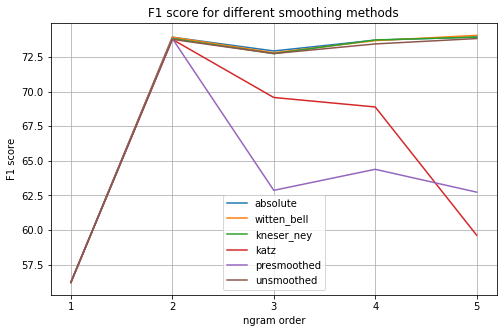

cutoff:  1
           0          1          2          3          4
0  56.219129  73.927711  72.933396  73.714016  73.941675
1  56.219129  73.927711  72.804533  73.679245  74.060150
2  56.219129  73.831325  72.744450  73.728814  73.931423
3  56.219129  73.770492  69.573371  68.889904  59.627832
4  56.219129  73.831325  62.869379  64.389411  62.738448
5  56.219129  73.770492  72.744450  73.440454  73.828680


In [25]:
ngrams = [1,2,3,4,5]
smoothing_methods = ["absolute", "witten_bell", "kneser_ney", "katz", "presmoothed", "unsmoothed"]
f1scores = []

with open("baseline/scores/cf{}.alpha{}.txt".format(tf_min,alpha), 'w') as f:
    f.write("Cutoff: {}\tAlpha: {}\n".format(tf_min,alpha))               
    for sm in smoothing_methods:
        sms = []    
        f.write("Smoothing method: {}\n".format(sm))
        for ngo in ngrams:

            refs = read_corpus_conll('dataset/tst.conll')
            hyps = read_fst4conll('baseline/result/pred.'+sm+'.'+str(ngo)+'.txt')

            results = evaluate(refs, hyps)

            pd_tbl = pd.DataFrame().from_dict(results, orient='index').iloc[-1:]
            val = pd.DataFrame().from_dict(results, orient='index').iloc[-1,pd_tbl.columns.get_loc('f')]*100
            sms.append(val)
            f.write("{}: {}\t".format(ngo,round(val,3)))

        f1scores.append(sms)
        f.write("\n")

#------------------PLOT---------------------
plt.figure(figsize=(8,5))
for sm in range(len(smoothing_methods)):
    plt.plot(ngrams,f1scores[sm], label=smoothing_methods[sm])
plt.title("F1 score for different smoothing methods")
plt.xlabel("ngram order")
plt.ylabel("F1 score")
plt.legend(loc='best')
plt.xticks(ngrams)
plt.grid()
plt.show()



print("cutoff: ",tf_min)
print(pd.DataFrame(f1scores))